### Full Name : Mahdi Tabatabaei 
### Student Number : 400101515


# Support Vector Machines (SVM)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## Goal
In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [2]:
df = pd.read_csv("Liver_Disease.csv") 

### Pre-Processing

#### Exploratory Data Analysis:
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

In [3]:
# Find the shape of the dataset.
df.shape

(583, 11)

In [4]:
# Check if there is missing entries in the dataset columnwise.
print(df.isnull().sum())

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64


In [5]:
# Check if the dataset is balanced or not
if 'label' in df.columns:
    print("Label class distribution:")
    print(df['label'].value_counts())
else:
    print("No Label column found in the dataset.")

Label class distribution:
label
1    416
2    167
Name: count, dtype: int64


The dataset is imbalanced and number of datapoints with label 1 is more than twice of datapoints with label 2.

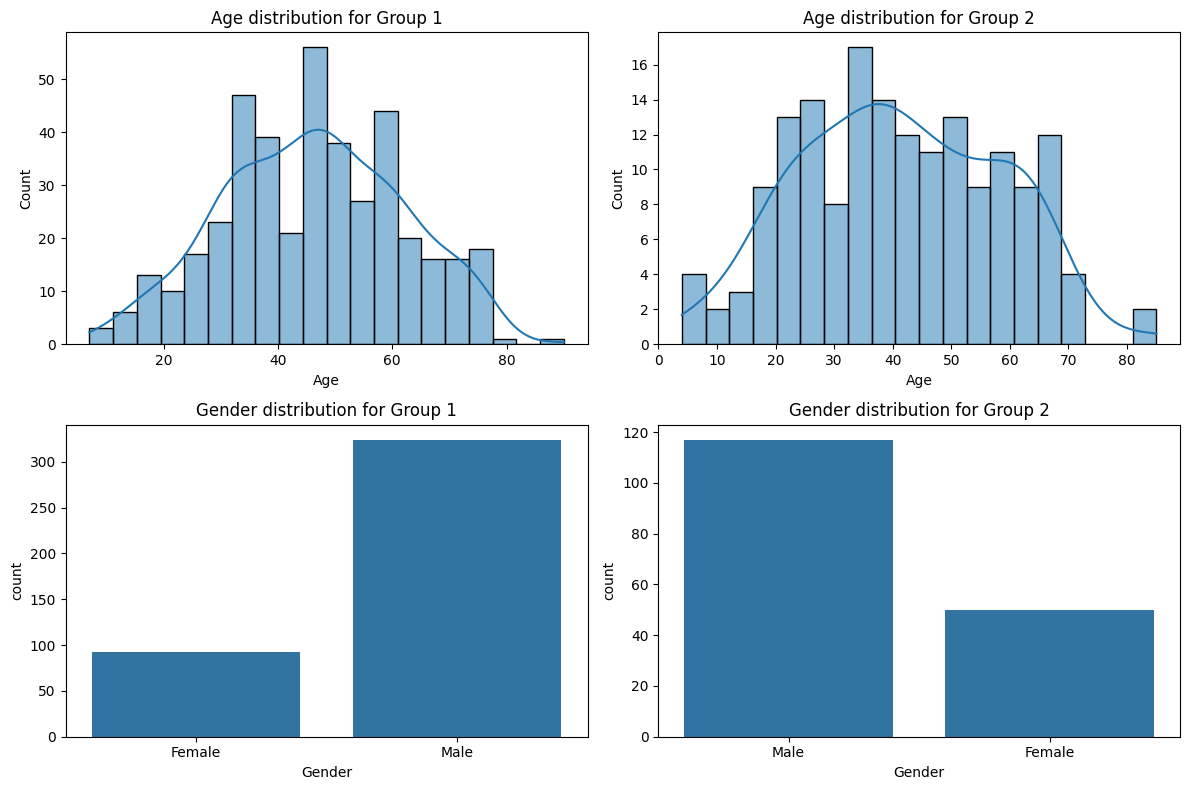

In [6]:
# 4. plot the age distirbution and gender distrbution for both group of patients.(4 plots)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Age distribution for group 1
sns.histplot(df[df['label'] == 1]['Age'], bins=20, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Age distribution for Group 1')

# Age distribution for group 0
sns.histplot(df[df['label'] == 2]['Age'], bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Age distribution for Group 2')

# Gender distribution for group 1
sns.countplot(x='Gender', data=df[df['label'] == 1], ax=axs[1, 0])
axs[1, 0].set_title('Gender distribution for Group 1')

# Gender distribution for group 0
sns.countplot(x='Gender', data=df[df['label'] == 2], ax=axs[1, 1])
axs[1, 1].set_title('Gender distribution for Group 2')

plt.tight_layout()
plt.show()

##### Question: What do you conclude from the plots?

- **Age Distribution:** Group 1 consists primarily of middle-aged to older individuals, while Group 2 has a higher proportion of younger individuals. This suggests potential differences in health conditions or risk factors associated with different age groups.
  
- **Gender Distribution:** Both groups are predominantly male, with a more significant gender imbalance in Group 1 compared to Group 2. This may indicate that the condition being studied disproportionately affects males, or there could be sampling bias toward male patients.


#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

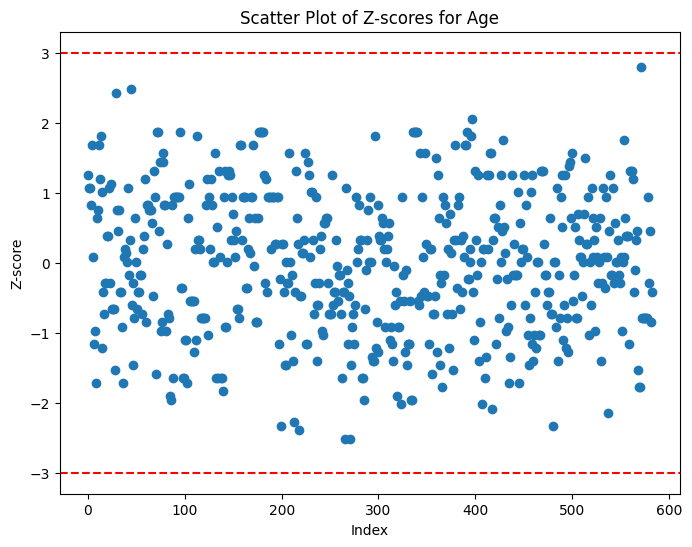

In [7]:
import pandas as pd
from scipy import stats

df_to_check = df.copy()
# Calculate the z-scores for the 'age' column
df_to_check['z_score_age'] = stats.zscore(df_to_check['Age'])
# Scatter plot to visualize Z-scores for age
plt.figure(figsize=(8, 6))
plt.scatter(df_to_check.index, df_to_check['z_score_age'])
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.title('Scatter Plot of Z-scores for Age')
plt.ylabel('Z-score')
plt.xlabel('Index')
plt.show()

I have analyzed the dataset for outliers using three methods: **Z-score**, **IQR method**, and **Tukey's fences**. It appears that there are no detected outliers in the dataset based on age using any of these methods.

In [8]:
# Reimporting necessary libraries and loading the dataset again
import pandas as pd
from scipy import stats

# Calculate z-scores for all numerical columns in the dataset
numerical_columns = df_to_check.select_dtypes(include=['float64', 'int64']).columns

# Function to calculate outliers based on Z-scores for all columns
def detect_outliers_zscore(df, columns, threshold=3):
    outliers = pd.DataFrame()
    for column in columns:
        z_scores = stats.zscore(df[column])
        df['z_score_' + column] = z_scores
        outliers_for_column = df[(z_scores > threshold) | (z_scores < -threshold)][[column, 'z_score_' + column]]
        if not outliers_for_column.empty:
            outliers = pd.concat([outliers, outliers_for_column], axis=0)
    return outliers

# Detect outliers in all numerical columns using Z-scores
z_score_outliers_all_columns = detect_outliers_zscore(df_to_check, numerical_columns)

# Remove the detected outliers from the original dataframe
df = df.drop(z_score_outliers_all_columns.index)

I have dropped 45 datapoints from my dataset by z-score analyzing.

In [9]:
df.shape

(538, 11)

#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [10]:
# Normalize numerical features to be between 0 and 1                   
# Note that just numerical fetures should be normalized.    
from sklearn.preprocessing import MinMaxScaler

# Define the label column (replace 'label' with the actual name if different)
label_column = 'label'

# Select only the numerical columns excluding the label column
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.difference([label_column])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the numerical features to be between 0 and 1 (excluding the label)
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])              

In [11]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,label
0,0.709302,Female,0.015625,0.000000,0.139797,0.009804,0.008511,0.533333,0.521739,0.240,1
1,0.674419,Male,0.546875,0.574468,0.717024,0.088235,0.095745,0.650000,0.500000,0.176,1
2,0.674419,Male,0.359375,0.425532,0.481398,0.081699,0.061702,0.566667,0.521739,0.236,1
3,0.627907,Male,0.031250,0.031915,0.134160,0.006536,0.010638,0.533333,0.543478,0.280,1
4,0.790698,Male,0.182292,0.202128,0.148816,0.027778,0.052128,0.616667,0.326087,0.040,1


Set Male and Female to 1 and 0

In [15]:
# Convert 'Male' to 1 and 'Female' to 0
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})

# Verify the conversion
print(df['Gender'].value_counts())

Gender
1    405
0    133
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23224\995563340.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})


Set labels 1, 0 instead of 1, 2

In [12]:
# Convert labels 2 to 0 (assuming 1 is the positive class and 2 is the negative class)
df['label'] = df['label'].replace({2: 0})

# Verify the conversion
print(df['label'].value_counts())

label
1    372
0    166
Name: count, dtype: int64


Removing rows which contain Nan input.

In [18]:
# Drop all rows that contain NaN values
df = df.dropna()
df.shape

(534, 11)

### SVM

#### spliting data

In [19]:
# Split the data into test and training sets.

from sklearn.model_selection import train_test_split

# Define the features and label
X = df.drop(columns=['label'])  # Features (all columns except the label)
y = df['label']  # Label (target)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets to verify the split
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (427, 10)
Testing features shape: (107, 10)
Training labels shape: (427,)
Testing labels shape: (107,)


### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM classifier
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Train the SVM model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.5607476635514018
Confusion Matrix:
[[19  5]
 [42 41]]
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.79      0.45        24
           1       0.89      0.49      0.64        83

    accuracy                           0.56       107
   macro avg       0.60      0.64      0.54       107
weighted avg       0.76      0.56      0.59       107



#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

# Split the training data into training and validation sets (80% train, 20% validation)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient for 'rbf'
    'class_weight': [None, 'balanced']
}

# Initialize the SVM model
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_part, y_train_part)

# Output the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print(f"Validation accuracy with best parameters: {val_score}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 10, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf'}
Validation accuracy with best parameters: 0.7209302325581395


Train an svm model on the entire training data using the parameters you found in the previous step.

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM model with the best parameters from the grid search
svm_model_best = SVC(C=10, kernel='rbf', gamma=1, class_weight='balanced')

# Train the SVM model on the entire training dataset
svm_model_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = svm_model_best.predict(X_test)

# Evaluate the model performance on the test data
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

# Output the test accuracy, confusion matrix, and classification report
print(f"Test accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Test accuracy: 0.6261682242990654
Confusion Matrix:
[[18  6]
 [34 49]]
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.75      0.47        24
           1       0.89      0.59      0.71        83

    accuracy                           0.63       107
   macro avg       0.62      0.67      0.59       107
weighted avg       0.77      0.63      0.66       107



### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

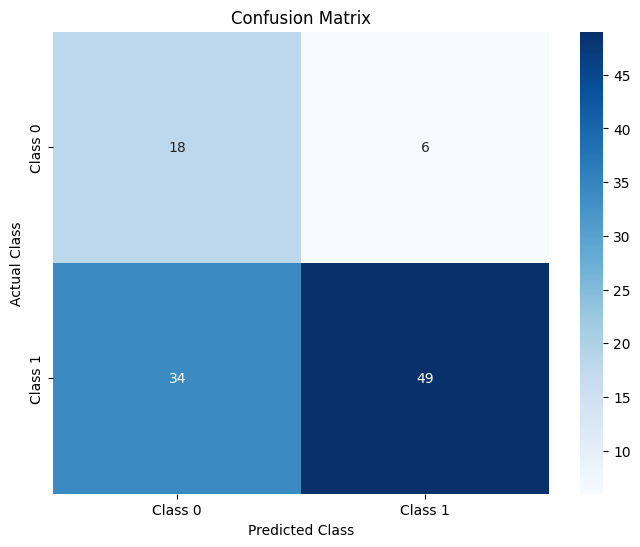

Test Accuracy: 0.6262


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming y_test and y_pred_test are already defined from the previous steps

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create labels for the confusion matrix
labels = ['Class 0', 'Class 1']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_test)

# Print the accuracy
print(f"Test Accuracy: {accuracy:.4f}")


**Entry of confusion matrix**

**Top-left (TN)**: The model correctly predicted Class 0 when the actual class was Class 0.

**Top-right (FP)**: The model incorrectly predicted Class 1 when the actual class was Class 0.

**Bottom-left (FN)**: The model incorrectly predicted Class 0 when the actual class was Class 1.

**Bottom-right (TP)**: The model correctly predicted Class 1 when the actual class was Class 1.

Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

We add 5 oiutliers to the dataset

In [46]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Step 1: Add some outliers to the dataset

# Create a copy of the cleaned dataset
df_outliers = df.copy()

# Introduce outliers in a few random rows by adding large values to some numerical columns
np.random.seed(42)
outlier_indices = np.random.choice(df_outliers.index, size=5, replace=False)

# Add extreme values to some columns for these selected rows
df_outliers.loc[outlier_indices, 'Total_Bilirubin'] *= 10  # Exaggerate Total Bilirubin values for these rows
df_outliers.loc[outlier_indices, 'Alkaline_Phosphotase'] *= 20  # Exaggerate Alkaline Phosphotase values for these rows

# Step 2: Train an SVM Model with the dataset containing outliers
X_outliers = df_outliers.drop(columns=['label'])
y_outliers = df_outliers['label']

# Split the dataset into training and test sets
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=42)

# Train an SVM model
svm_model = SVC(C=10, kernel='rbf', gamma=1, class_weight='balanced')
svm_model.fit(X_train_out, y_train_out)
y_pred_svm = svm_model.predict(X_test_out)

# Step 3: Train a Logistic Regression Model with the same dataset
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_model.fit(X_train_out, y_train_out)
y_pred_logreg = log_reg_model.predict(X_test_out)

# Step 4: Compare the results of both models

# SVM Results
accuracy_svm = accuracy_score(y_test_out, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test_out, y_pred_svm)
class_report_svm = classification_report(y_test_out, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Confusion Matrix:")
print(conf_matrix_svm)
print("SVM Classification Report:")
print(class_report_svm)

# Logistic Regression Results
accuracy_logreg = accuracy_score(y_test_out, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test_out, y_pred_logreg)
class_report_logreg = classification_report(y_test_out, y_pred_logreg)

print(f"Logistic Regression Accuracy: {accuracy_logreg}")
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_logreg)
print("Logistic Regression Classification Report:")
print(class_report_logreg)


SVM Accuracy: 0.6448598130841121
SVM Confusion Matrix:
[[17  7]
 [31 52]]
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.71      0.47        24
           1       0.88      0.63      0.73        83

    accuracy                           0.64       107
   macro avg       0.62      0.67      0.60       107
weighted avg       0.76      0.64      0.67       107

Logistic Regression Accuracy: 0.6728971962616822
Logistic Regression Confusion Matrix:
[[16  8]
 [27 56]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.67      0.48        24
           1       0.88      0.67      0.76        83

    accuracy                           0.67       107
   macro avg       0.62      0.67      0.62       107
weighted avg       0.76      0.67      0.70       107



Logistic Regression performs better than SVM with rbf kernel on this dataset.